# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
import numpy as np, pandas as pd

!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 9.5MB 32.6MB/s 
     |████████████████████████████████| 5.4MB 20.8MB/s 
     |████████████████████████████████| 26.6MB 118kB/s 
     |████████████████████████████████| 2.6MB 38.4MB/s 
  Created wheel for wrangle: filename=wrangle-0.6.7-cp37-none-any.whl size=49894 sha256=a0a746c56421c7fc2ca32b6f59773a4e7ba7356991c9221efcaaa115ba4836ea
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp37-none-any.whl size=3603 sha256=ec4bb7f693a02ebb1b478be503224ecc486f97b348fbe27530bdcd1d0b8da1ba
  Stored in directory: /root/.cache/pip/wheels/9d/d3/8c/9503a22b0a38e8b21c70ad834e4606d209193443e5c709305d
  Created wheel for chances: filename=chances-0.1.9-cp37-none-any.whl size=41610 sha256=a3b8bf91c464792fdf88dafde46c811a7567008ad9f1d85c866a197b42533099
  Stored in directory: /root/.cache/pip/

# Importing Data

In [ ]:
!git clone https://github.com/shaunak09vb/Toxic-Comment-Classifier-using-Deep-Learning.git

Cloning into 'Toxic-Comment-Classifier-using-Deep-Learning'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 69 (delta 21), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (69/69), done.
Checking out files: 100% (6/6), done.


In [ ]:
train_path = "/content/Toxic-Comment-Classifier-using-Deep-Learning/Data/train.csv"
test_path = "/content/Toxic-Comment-Classifier-using-Deep-Learning/Data/test.csv"
test_labels_path = "/content/Toxic-Comment-Classifier-using-Deep-Learning/Data/test_labels.csv"

In [ ]:
train=pd.read_csv(train_path)    

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test=pd.read_csv(test_path)

In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# Data Exploration

Checking for missing values

In [ ]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
test.isnull().any()


id              False
comment_text    False
dtype: bool

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

Cleaning Training Data

In [ ]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [ ]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

## Lemmatization

In [ ]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [ ]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [ ]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

In [ ]:
lemmatized_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

Lemmatizing Test Data

In [ ]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

## Stopwords Removal

In [ ]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS

In [ ]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [ ]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [ ]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [ ]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [ ]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

In [ ]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [ ]:
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [ ]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

Counting the number of words in each of the 4 strings

In [ ]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [ ]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

Converting Dictionaries to Dataframe

In [ ]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [ ]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

Looking for common terms in all top 50 dataframes

In [ ]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [ ]:
print(common_potential_stopwords)

['editor', 'question', 'user', 'new', 'thing', 'talk', 'list', 'page', 'remove', 'work', 'article', 'look', 'don', 'help', 'mean', 'try', 'add', 'like', 'source', 'delete', 'good', 'find', 'comment', 'wikipedia', 'block', 'read', 'link', 'thank', 'time', 'think', 'write', 'point', 'fact', 'doe', 'reference', 'need', 'fuck', 'know', 'want', 'information', 'use', 'way', 'change', 'deletion', 'image', 'section', 'edit', 'people']


Retaining certain words and removing others from the above list

In [ ]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [ ]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [ ]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [ ]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

In [ ]:
processed_train_data[152458]

'agree graemel intention revert nazi protect report revert rule notice board post report revert nazi graemel revert nazi unacceptable site admins feel unjustly revert hour period report revert noticeboard'

Removing Stopwords from Test Data

In [ ]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

# Model Building

In [ ]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [ ]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  148917


Padding

In [ ]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [ ]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

In [ ]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [ ]:
X_t = X_t[indices]
labels = y[indices]

In [ ]:
labels

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0]])

### Splitting data into Training and Validation Set

In [ ]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [ ]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12193  1249  6730   378  6220  1126]
validation:  [3101  346 1719  100 1657  279]


### Importing Fast Text

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2021-06-23 15:10:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  12.0MB/s    in 56s     

2021-06-23 15:11:11 (11.6 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

unzip:  cannot find or open vectors-english/wiki-news-300d-1M.vec.zip, vectors-english/wiki-news-300d-1M.vec.zip.zip or vectors-english/wiki-news-300d-1M.vec.zip.ZIP.


In [ ]:
!unzip "wiki-news-300d-1M.vec.zip"

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
embeddings_index_fasttext = {}
f = open("/content/wiki-news-300d-1M.vec", encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [ ]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


### Creating Model

#### Talos Grid Search  for LSTM Model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 173s 37ms/step - loss: 0.0896 - accuracy: 0.8261 - val_loss: 0.0499 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 141s 35ms/step - loss: 0.0506 - accuracy: 0.9880 - val_loss: 0.0470 - val_accuracy: 0.9939


  6%|▌         | 1/18 [05:47<1:38:27, 347.51s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 179s 44ms/step - loss: 0.0875 - accuracy: 0.8420 - val_loss: 0.0516 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 175s 44ms/step - loss: 0.0502 - accuracy: 0.9930 - val_loss: 0.0479 - val_accuracy: 0.9938


 11%|█         | 2/18 [12:13<1:35:44, 359.05s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 182s 45ms/step - loss: 0.0865 - accuracy: 0.8265 - val_loss: 0.0500 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 179s 45ms/step - loss: 0.0503 - accuracy: 0.9860 - val_loss: 0.0465 - val_accuracy: 0.9931


 17%|█▋        | 3/18 [18:39<1:31:46, 367.09s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 155s 38ms/step - loss: 0.0902 - accuracy: 0.8075 - val_loss: 0.0504 - val_accuracy: 0.9920
Epoch 2/2
3990/3990 [==============================] - 145s 36ms/step - loss: 0.0503 - accuracy: 0.9708 - val_loss: 0.0471 - val_accuracy: 0.9916


 22%|██▏       | 4/18 [24:05<1:22:46, 354.75s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 179s 44ms/step - loss: 0.0908 - accuracy: 0.8571 - val_loss: 0.0493 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 176s 44ms/step - loss: 0.0501 - accuracy: 0.9840 - val_loss: 0.0474 - val_accuracy: 0.9939


 28%|██▊       | 5/18 [30:31<1:18:53, 364.10s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 181s 45ms/step - loss: 0.0824 - accuracy: 0.8411 - val_loss: 0.0501 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 179s 45ms/step - loss: 0.0505 - accuracy: 0.9885 - val_loss: 0.0464 - val_accuracy: 0.9939


 33%|███▎      | 6/18 [36:57<1:14:07, 370.64s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 150s 37ms/step - loss: 0.0910 - accuracy: 0.8193 - val_loss: 0.0496 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 141s 35ms/step - loss: 0.0493 - accuracy: 0.9847 - val_loss: 0.0475 - val_accuracy: 0.9929


 39%|███▉      | 7/18 [42:22<1:05:29, 357.21s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 179s 44ms/step - loss: 0.0849 - accuracy: 0.8678 - val_loss: 0.0492 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 176s 44ms/step - loss: 0.0496 - accuracy: 0.9871 - val_loss: 0.0476 - val_accuracy: 0.9902


 44%|████▍     | 8/18 [48:19<59:30, 357.00s/it]  

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 180s 45ms/step - loss: 0.0829 - accuracy: 0.8605 - val_loss: 0.0490 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 177s 44ms/step - loss: 0.0492 - accuracy: 0.9888 - val_loss: 0.0462 - val_accuracy: 0.9935


 50%|█████     | 9/18 [54:45<54:51, 365.67s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 145s 36ms/step - loss: 0.1023 - accuracy: 0.7750 - val_loss: 0.0526 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 135s 34ms/step - loss: 0.0535 - accuracy: 0.9867 - val_loss: 0.0486 - val_accuracy: 0.9940


 56%|█████▌    | 10/18 [59:26<45:22, 340.35s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 178s 44ms/step - loss: 0.0911 - accuracy: 0.7626 - val_loss: 0.0520 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 175s 44ms/step - loss: 0.0525 - accuracy: 0.9902 - val_loss: 0.0480 - val_accuracy: 0.9940


 61%|██████    | 11/18 [1:05:20<40:10, 344.37s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 30, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 180s 44ms/step - loss: 0.0995 - accuracy: 0.7322 - val_loss: 0.0502 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 175s 44ms/step - loss: 0.0520 - accuracy: 0.9856 - val_loss: 0.0473 - val_accuracy: 0.9940


 67%|██████▋   | 12/18 [1:11:46<35:40, 356.83s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 144s 36ms/step - loss: 0.0922 - accuracy: 0.8335 - val_loss: 0.0513 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 136s 34ms/step - loss: 0.0527 - accuracy: 0.9896 - val_loss: 0.0479 - val_accuracy: 0.9940


 72%|███████▏  | 13/18 [1:16:28<27:51, 334.36s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 178s 44ms/step - loss: 0.0955 - accuracy: 0.7654 - val_loss: 0.0500 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 175s 44ms/step - loss: 0.0521 - accuracy: 0.9844 - val_loss: 0.0474 - val_accuracy: 0.9940


 78%|███████▊  | 14/18 [1:22:54<23:19, 349.81s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 40, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 180s 44ms/step - loss: 0.1001 - accuracy: 0.7369 - val_loss: 0.0500 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 177s 44ms/step - loss: 0.0514 - accuracy: 0.9915 - val_loss: 0.0474 - val_accuracy: 0.9940


 83%|████████▎ | 15/18 [1:28:52<17:37, 352.50s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 40}
Epoch 1/2
3990/3990 [==============================] - 143s 35ms/step - loss: 0.1001 - accuracy: 0.8042 - val_loss: 0.0491 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 135s 34ms/step - loss: 0.0506 - accuracy: 0.9884 - val_loss: 0.0477 - val_accuracy: 0.9940


 89%|████████▉ | 16/18 [1:33:31<11:00, 330.47s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 50}
Epoch 1/2
3990/3990 [==============================] - 178s 44ms/step - loss: 0.0907 - accuracy: 0.8111 - val_loss: 0.0509 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 175s 44ms/step - loss: 0.0509 - accuracy: 0.9863 - val_loss: 0.0470 - val_accuracy: 0.9940


 94%|█████████▍| 17/18 [1:39:57<05:47, 347.08s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 2, 'last_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'output_count_dense': 50, 'output_count_lstm': 60}
Epoch 1/2
3990/3990 [==============================] - 181s 45ms/step - loss: 0.0945 - accuracy: 0.8033 - val_loss: 0.0501 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 176s 44ms/step - loss: 0.0516 - accuracy: 0.9793 - val_loss: 0.0473 - val_accuracy: 0.9940


100%|██████████| 18/18 [1:45:55<00:00, 353.10s/it]


In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

16

In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[385.1305978298187, '06/23/21-165435', 0.2, 2, 50, 'sigmoid',
        'adam', 50, '06/23/21-164810', 32, 'relu', 2, 0],
       [280.60878467559814, '06/23/21-161404', 0.2, 2, 40, 'sigmoid',
        'adam', 30, '06/23/21-160924', 32, 'relu', 2, 1],
       [353.0778503417969, '06/23/21-161958', 0.2, 2, 50, 'sigmoid',
        'adam', 30, '06/23/21-161405', 32, 'relu', 2, 2],
       [278.4076943397522, '06/23/21-164810', 0.2, 2, 40, 'sigmoid',
        'adam', 50, '06/23/21-164331', 32, 'relu', 2, 3],
       [358.1005048751831, '06/23/21-164331', 0.2, 2, 60, 'sigmoid',
        'adam', 40, '06/23/21-163733', 32, 'relu', 2, 4],
       [385.21705865859985, '06/23/21-163732', 0.2, 2, 50, 'sigmoid',
        'adam', 40, '06/23/21-163107', 32, 'relu', 2, 5],
       [281.25628900527954, '06/23/21-163106', 0.2, 2, 40, 'sigmoid',
        'adam', 40, '06/23/21-162625', 32, 'relu', 2, 6],
       [385.24834060668945, '06/23/21-162624', 0.2, 2, 60, 'sigmoid',
        'adam', 30, '06/23/21-161959',

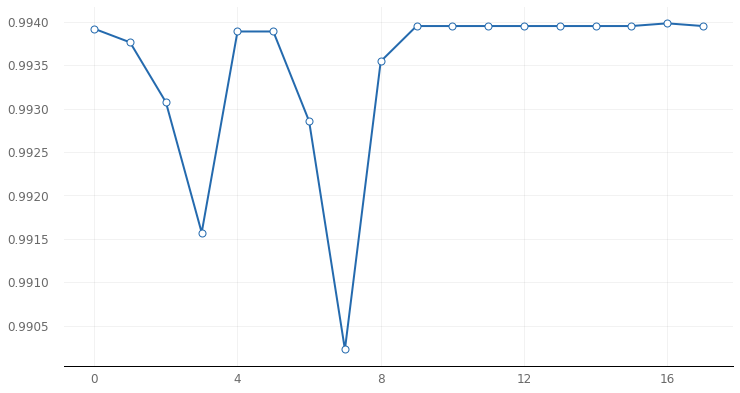

In [ ]:
analyze_object.plot_line('val_accuracy')

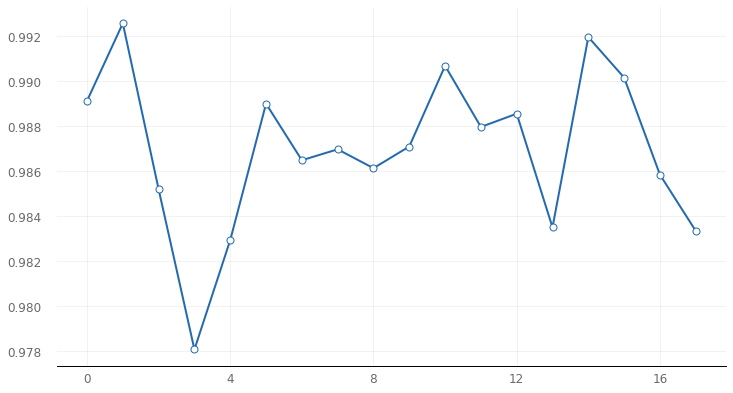

In [ ]:
analyze_object.plot_line('accuracy')

#### Talos Grid Search  for LSTM-CNN Model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

  x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)

  x = MaxPooling1D(params['pool_size'])(x)
  
  x = GlobalMaxPool1D()(x)
  
  x = BatchNormalization()(x)
  
  x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)

  x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [50,60],
    'output_1_count_dense': [40,50],
    'output_2_count_dense': [30,40],
    'filters' : [64],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [3],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

In [ ]:
scan_results.data[8:9]

In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

In [ ]:
analyze_object.plot_line('val_accuracy')

In [ ]:
analyze_object.plot_line('accuracy')

#### Training Model with Best Parameters

LSTM

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 300)          44675400  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 40)           54560     
_________________________________________________________________
global_max_pooling1d (Global (None, 40)                0         
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1230      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0     

In [ ]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 144s 36ms/step - loss: 0.0861 - accuracy: 0.8277 - val_loss: 0.0520 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 137s 34ms/step - loss: 0.0514 - accuracy: 0.9794 - val_loss: 0.0481 - val_accuracy: 0.9939


LSTM-CNN

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_2.summary()

In [ ]:
model_info_2=model_2.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

## Plotting Graphs

### LSTM

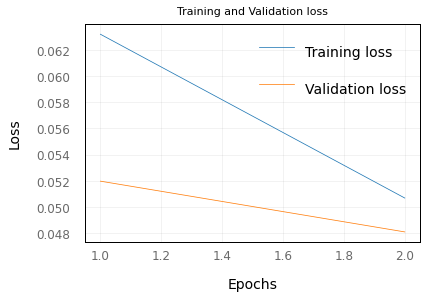

In [ ]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

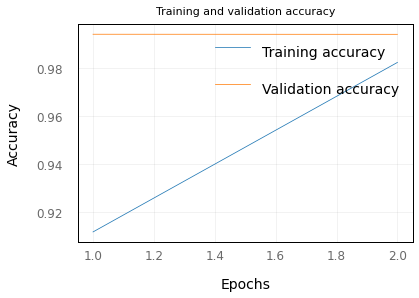

In [ ]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

### LSTM-CNN

In [ ]:
loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
accuracy = model_info_2.history['accuracy']
val_accuracy = model_info_2.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [ ]:
model_1.save(filepath="toxic_lstm.h5")

In [ ]:
model_2.save(filepath="File_Path")

# Loading Saved Model

In [ ]:
loaded_model_1 = keras.models.load_model(filepath="toxic_lstm.h5")

In [ ]:
loaded_model_2 = keras.models.load_model(filepath="File_Path")

# Generating the Output

### LSTM

In [ ]:
test_values_1 = loaded_model_1.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 1215s 8ms/step


In [ ]:
sample_submission = pd.read_csv('/content/Toxic-Comment-Classifier-using-Deep-Learning/Data/sample_submission.csv')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv('submission.csv', index=False)

### LSTM-CNN

In [ ]:
test_values_2 = loaded_model_2.predict([X_te], batch_size=1, verbose=1)

In [ ]:
sample_submission = pd.read_csv('File_Path')
test_values_2=pd.DataFrame(test_values_2,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_2],axis=1)
combined_submission.to_csv('File_Path', index=False)

# Testing the Created Model

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = model_1.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)

    print(prediction)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [ ]:
toxicity_level('go jump off a bridge jerk')

[[0.7924861  0.01510376 0.4375913  0.01315    0.43525594 0.01644641]]
Toxicity levels for 'go jump off a bridge jerk':
Toxic:         79%
Severe Toxic:  2%
Obscene:       44%
Threat:        1%
Insult:        44%
Identity Hate: 2%



In [ ]:
toxicity_level('i will kill you')

Toxicity levels for 'i will kill you':
Toxic:         21%
Severe Toxic:  1%
Obscene:       5%
Threat:        5%
Insult:        5%
Identity Hate: 3%



In [ ]:
toxicity_level('have a nice day')

Toxicity levels for 'have a nice day':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('fuck ofF!!')

Toxicity levels for 'fuck ofF!!':
Toxic:         99%
Severe Toxic:  20%
Obscene:       93%
Threat:        3%
Insult:        68%
Identity Hate: 3%



In [ ]:
toxicity_level('Hello, How are you?')

Toxicity levels for 'Hello, How are you?':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('get the fuck away from me @sshole!!')

[[0.9639315  0.12829417 0.88818866 0.02603332 0.61226356 0.02584922]]
Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         96%
Severe Toxic:  13%
Obscene:       89%
Threat:        3%
Insult:        61%
Identity Hate: 3%

